In [1]:
import os
import PIL
import time
import imageio
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import matplotlib.pyplot as pt

from glob import glob
from tqdm import tqdm
from typing import Iterable, List, Tuple, Any

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

In [4]:
data_dir = 'data'
random_image_dir = os.path.join(data_dir, 'random_images')
vangogh_image_dir = os.path.join(data_dir, 'vangogh_images')

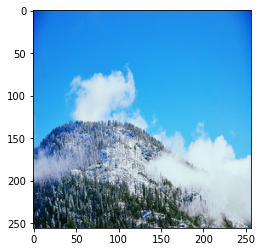

In [5]:
pt.imshow(load_random_image(random_image_dir, "*.jpg"))

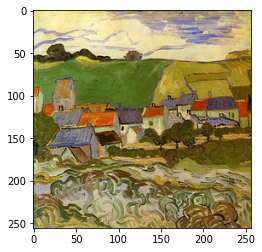

In [6]:
pt.imshow(load_random_image(vangogh_image_dir, "*.jpg"))

In [7]:
BATCH_SIZE = 1
DATASET_SIZE = len(list_files(random_image_dir, "*.jpg")) + len(list_files(vangogh_image_dir, "*.jpg"))

In [8]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.95, 1.2),
    validation_split = 0.2,
)

gen_params = dict(
    target_size       =  (32, 32),
    batch_size        =  BATCH_SIZE,
    color_mode        =  'rgb',
    class_mode        =  'binary',
)

In [9]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

train_gen = dgen.flow_from_directory(
    data_dir, 
    subset="training",
    **gen_params,
)

val_gen = dgen.flow_from_directory(
    data_dir, 
    subset="validation",
    **gen_params,
)

Found 16263 images belonging to 3 classes.
Found 4065 images belonging to 3 classes.


In [10]:
train_dataset = tfd.Dataset.from_generator(lambda: train_gen, (tf.float32, tf.int32))
eval_dataset = tfd.Dataset.from_generator(lambda: val_gen, (tf.float32, tf.int32))

[1]


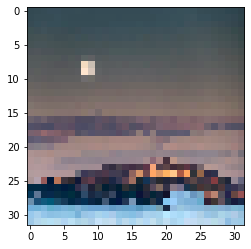

In [11]:
for img, label in train_dataset.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

[1]


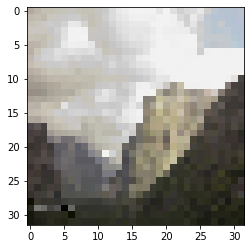

In [12]:
for img, label in eval_dataset.take(1).as_numpy_iterator():
    print(label)
    pt.imshow(img[0, ...])

## We have downscaled all images to 128 x 128 to make them easier to process

In [13]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [14]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Note that _preprocess() above returns image, image rather than just image because Keras is set up for discriminative models with an (example, label) input format. Since the goal of the VAE is to recover the input x from x itself, the data pair is (example, example).

In [15]:
# datasets, datasets_info = tfds.load(name='mnist',
#                                     with_info=True,
#                                     as_supervised=False)

# print(datasets_info.features['image'].shape)
# print(datasets_info.)
def _preprocess(sample, label):
    image = tf.cast(sample[0, ...], tf.float32) / 255.  # Scale to unit interval.
#     image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

train_dataset = (train_dataset
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE))
#                  .shuffle(int(10e2)))
eval_dataset = (eval_dataset
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))


In [16]:
# input_shape = datasets_info.features['image'].shape
input_shape = (32, 32, 3)
encoded_size = 16
base_depth = 32


In [17]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [18]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 3, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [19]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 4, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(3, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.UpSampling2D((2,2), interpolation='nearest' )
#     tfkl.Conv2D(filters=3, kernel_size=5, strides=1,
#                 padding='same', activation=None),
#     tfkl.Flatten(),
#     tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

# decoder_input = tfkl.InputLayer(input_shape=[encoded_size])
# decoder_layer = tfkl.Reshape([1, 1, encoded_size])(decoder_input)
# decoder_layer = tfkl.Conv2DTranspose(2 * base_depth, 3, strides=1,
#                          padding='valid', activation=tf.nn.leaky_relu)(decoder_layer)
# decoder_layer = tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu)(decoder_layer)
# decoder_layer = tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu)(decoder_layer)
# decoder_layer = tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu)(decoder_layer)
# decoder_layer = tfkl.Conv2DTranspose(base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu)(decoder_layer)
# decoder_layer = tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu)(decoder_layer)

# decoder_layer = tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                             padding='same', activation=None)(decoder_layer)
# decoder_layer = tfkl.Flatten()(decoder_layer)
# decoder_layer = tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits)(decoder_layer)

# decoder = tf.keras.models.Model(inputs=decoder_input, outputs=decoder_layer)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 64)          16448     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 64)          102464    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 32)          51232     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 32)          25632     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 3)        

In [20]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

In [21]:
# negloglik = lambda x, rv_x: -rv_x.log_prob(x)
def autoencoder_loss(original_image, decoded_image):
    return tf.keras.losses.MSE(original_image, decoded_image)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=autoencoder_loss)
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928 

In [22]:
_ = vae.fit(train_dataset.take(250),
            epochs=1,
            validation_data=eval_dataset)

    250/Unknown - 78s 292ms/step - loss: 0.1643

KeyboardInterrupt: 

In [23]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
# assert isinstance(xhat, tfd.Distribution)


In [24]:
images = []
for image, _ in eval_dataset.take(10).as_numpy_iterator():
    images.append(image)

In [29]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


Originals:


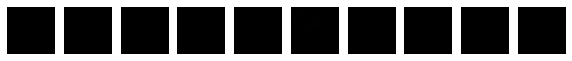

Decoded Random Samples:


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'sample'

In [30]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())


In [ ]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)


In [ ]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())


In [ ]:
for img, _ in train_dataset.take(1).as_numpy_iterator():
    print(img)